# **SSCS - Test Playground - tf.data**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

In [1]:
EXECUTE_ON_COLAB = False

In [2]:
import os
import h5py
import json
import math
import tables
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization

In [3]:
num_threads = 6
os.environ["OMP_NUM_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_threads)

tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.set_soft_device_placement(True)

## 2 - Neural Network Model (VoasCNN)

In [4]:
SAVE_MODEL = True
LOAD_MODEL = True
SPLIT_SIZE = 128
BATCH_SIZE = 32

In [5]:
def voas_cnn_model():
    x_in = Input(shape=(360, SPLIT_SIZE, 1))
    
    x = BatchNormalization()(x_in)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)

    ## start four branches now

    x = BatchNormalization()(x)

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    y1 = tf.squeeze(y1, axis=-1)
    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    y2 = tf.squeeze(y2, axis=-1)
    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    y3 = tf.squeeze(y3, axis=-1)
    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    y4 = tf.squeeze(y4, axis=-1)

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 3 - Auxiliar functions and Variables

Functions designed to manipulate the SSCS dataset.

### 3.1 - File path variables

In [6]:
if(EXECUTE_ON_COLAB):
    dataset_dir = "/content/Datasets/"
else:
    dataset_dir = "Datasets/"
zipname = dataset_dir + "SSCS_HDF5.zip"
sscs_dir = dataset_dir + "SSCS_HDF5/"

songs_dir = sscs_dir + "sscs/"
splitname = sscs_dir + "sscs_splits.json"

### 3.2 - Download/Extract Scripts

In [7]:
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
            
    print()

In [8]:
def sscs_download():
    
    if(not os.path.exists(dataset_dir)):
        os.mkdir(dataset_dir)
   
    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://github.com/Xornotor/SSCS_HDF5/releases/download/v1.0/SSCS_HDF5.zip"
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    if(not os.path.exists(sscs_dir)):
        print("Extracting SSCS Dataset...")
        with zipfile.ZipFile(zipname) as zf:
            os.mkdir(sscs_dir)
            zf.extractall(path=sscs_dir)
    else:
        print("SSCS Dataset already extracted.")
    

    print("Done.")

### 3.3 - Splits, songnames and songlists

In [9]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        return json.load(open(splitname, 'r'))[split.lower()]
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [10]:
def sscs_pick_songlist(first=0, amount=5, split='train'):
    
    songnames = sscs_get_split(split)
    return songnames[first:first+amount]

In [11]:
def sscs_pick_random_song(split='train'):
    
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [12]:
def sscs_pick_multiple_random_songs(amount, split='train'):
    
    return [sscs_pick_random_song() for i in range(amount)]

### 3.4 - Plots

In [18]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

## 4 - Download and extract dataset SSCS

In [13]:
sscs_download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 5 - Dataset Generator

In [14]:
class SSCS_Sequence(tf.keras.utils.Sequence):
    def __init__(self, filenames, batch_size=BATCH_SIZE):
        self.filenames = filenames
        self.batch_size = batch_size
        self.splits_amount = 0
        self.splits_per_file = np.array([], dtype=np.intc)
        self.songs_dir = songs_dir
        self.split_size = SPLIT_SIZE

        for file in self.filenames:
            file_access = self.songs_dir + file + ".h5"
            f = h5py.File(file_access, 'r')
            file_shape = f['mix/table'].shape[0]
            df_batch_items = file_shape//self.split_size
            #if(file_shape/self.split_size > df_batch_items): df_batch_items += 1
            self.splits_per_file = np.append(self.splits_per_file, int(df_batch_items))
            self.splits_amount += df_batch_items
            f.close()
        
    def __len__(self):
        return math.ceil(self.splits_amount/self.batch_size)

    def __getitem__(self, idx):
        mix_in = np.empty((0, 360, self.split_size))
        s_out = np.empty((0, 360, self.split_size))
        a_out = np.empty((0, 360, self.split_size))
        t_out = np.empty((0, 360, self.split_size))
        b_out = np.empty((0, 360, self.split_size))
  
        splits_past = idx * self.batch_size
        idx_get = 0
        if(idx > 0):
            while(splits_past > 0):
                splits_past -= self.splits_per_file[idx_get]
                if(splits_past > 0):
                    idx_get += 1
        split_get = self.splits_per_file[idx_get] + splits_past
        
        if(split_get == self.splits_per_file[idx_get]):
            idx_get += 1
            split_get = 0

        splits_to_compose = self.batch_size
        while(splits_to_compose > 0):
            file_access = self.songs_dir + self.filenames[idx_get] + ".h5"
            file_splits = self.splits_per_file[idx_get]
            
            if((file_splits - split_get) - splits_to_compose >= 0):
                split_max = split_get + splits_to_compose
            else:
                split_max = self.splits_per_file[idx_get]

            f = h5py.File(file_access, 'r')
            data_min = split_get * self.split_size
            data_max = split_max * self.split_size

            mix_aux = np.transpose(pd.read_hdf(file_access, 'mix')[data_min:data_max])
            s_aux = np.transpose(pd.read_hdf(file_access, 'soprano')[data_min:data_max])
            a_aux = np.transpose(pd.read_hdf(file_access, 'alto')[data_min:data_max])
            t_aux = np.transpose(pd.read_hdf(file_access, 'tenor')[data_min:data_max])
            b_aux = np.transpose(pd.read_hdf(file_access, 'bass')[data_min:data_max])

            mix_aux = np.array_split(mix_aux, mix_aux.shape[1]/self.split_size, axis=1)
            s_aux = np.array_split(s_aux, s_aux.shape[1]/self.split_size, axis=1)
            a_aux = np.array_split(a_aux, a_aux.shape[1]/self.split_size, axis=1)
            t_aux = np.array_split(t_aux, t_aux.shape[1]/self.split_size, axis=1)
            b_aux = np.array_split(b_aux, b_aux.shape[1]/self.split_size, axis=1)

            mix_aux = np.array(mix_aux)
            s_aux = np.array(s_aux)
            a_aux = np.array(a_aux)
            t_aux = np.array(t_aux)
            b_aux = np.array(b_aux)

            mix_in = np.append(mix_in, mix_aux, axis=0)
            s_out = np.append(s_out, s_aux, axis=0)
            a_out = np.append(a_out, a_aux, axis=0)
            t_out = np.append(t_out, t_aux, axis=0)
            b_out = np.append(b_out, b_aux, axis=0)

            f.close()

            splits_to_compose -= (file_splits - split_get)
            idx_get += 1
            split_get = 0
            if(idx_get >= len(self.filenames)):
                break

        return mix_in, [s_out, a_out, t_out, b_out]

    def get_splits_per_file(self):
        return self.splits_per_file

In [27]:
seq = SSCS_Sequence(sscs_get_split()[:1000], BATCH_SIZE)

In [29]:
seq.__len__()

2766

## 6 - Plot test

In [38]:
mix, satb = seq.__getitem__(np.random.randint(0, seq.__len__()))

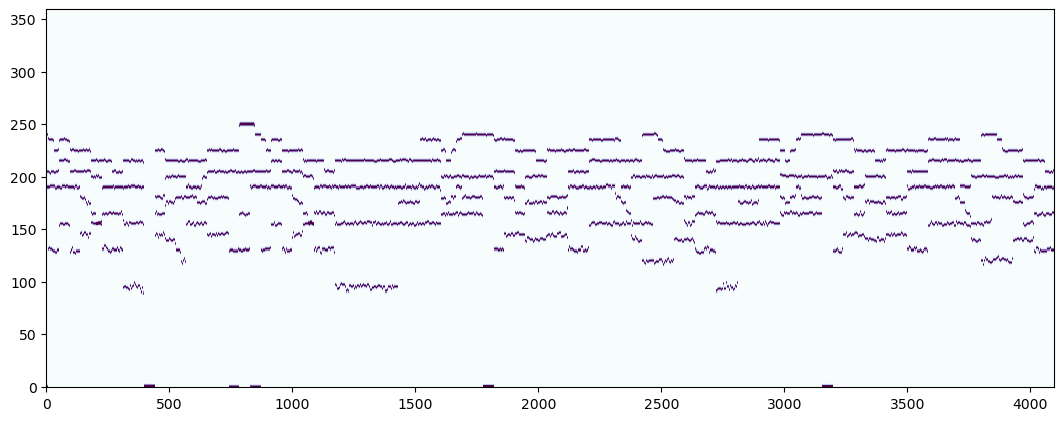

In [39]:
sscs_plot(np.reshape(np.moveaxis(mix, 0, 1), (360, -1)))